## City district delineation using Graph Neural Networks

### Graph Neural Networks


Graph Neural Networks (GNNs) are a class of deep learning methods designed to perform inference on data described by graphs. GNNs are neural networks that can be directly applied to graphs, and provide an easy way to do node-level, edge-level, and graph-level prediction tasks. 

Anything that is composed of linked entities can be represented as a graph. Graphs are excellent tools to visualize relations between people, objects, and concepts. With graphs becoming more pervasive and richer with information, and artificial neural networks becoming more popular and capable, GNNs have become a powerful tool for many important applications.

<img src='GNN.png' width="600" height="600">

Graph neural networks can be created like any other neural network, using fully connected layers, convolutional layers, pooling layers, etc. The type and number of layers depend on the type and complexity of the graph data and the desired output.

The GNN receives the formatted graph data as input and produces a vector of numerical values that represent relevant information about nodes and their relations. This vector representation is called “graph embedding.”

One very popular GNN architecture is the graph convolutional neural network (GCN), which uses convolution layers to create graph embeddings. (Kipf, T.N. and Welling, M., 2016. Semi-supervised classification with graph convolutional networks. https://arxiv.org/pdf/1609.02907.pdf)

In the recent years, a lot of work has been done on the problem of generalizing neural networks to work on arbitrarily structured graphs - Bruna, J., Zaremba, W., Szlam, A. and LeCun, Y., 2013. Spectral networks and locally connected networks on graphs. https://arxiv.org/pdf/1312.6203.pdf%20http://arxiv.org/abs/1312.6203.pdf,  Henaff, M., Bruna, J. and LeCun, Y., 2015. Deep convolutional networks on graph-structured data. https://arxiv.org/abs/1506.05163 etc.

 
Few applications for graph neural networks:

- Node classification: One of the powerful applications of GNNs is adding new information to nodes or filling gaps where information is missing. For example, say you are running a social network and you have spotted a few bot accounts. Now you want to find out if there are other bot accounts in your network. You can train a GNN to classify other users in the social network as “bot” or “not bot” based on how close their graph embeddings are to those of the known bots.

- Edge prediction: Another way to put GNNs to use is to find new edges that can add value to the graph. Going back to our social network, a GNN can find users (nodes) who are close to you in embedding space but who aren’t your friends yet (i.e., there isn’t an edge connecting you to each other). These users can then be introduced to you as friend suggestions.

- Clustering: GNNs can glean new structural information from graphs. For example, in a social network where everyone is in one way or another related to others (through friends, or friends of friends, etc.), the GNN can find nodes that form clusters in the embedding space.

### GNN for city delineation

Here, we demonstrate an application for GNN for city borough delineation. The relationships among various entities such as interaction among people, intra-city mobility, social media interactions can be interpreted in terms of graphs with many features associated with nodes, edges. 

We will use the LEHD mobility network among zip codes in NYC and use it to learn the corresponding borough of zip codes (nodes) in the city. 

In [305]:
# import packages

import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd
from utils import load_data,normalize,doublerelu
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
torch.set_printoptions(sci_mode=False)
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [306]:
import warnings
warnings.filterwarnings("ignore") 

#### Data overview

The LEHD mobility matrix contains the commute numbers between the home and work zip codes of the population...

In [307]:
data = pd.read_csv('zips_merged.csv', delimiter=',')
data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
data = data[data.destination.isin(data.origin.unique())]
data.head()

,origin,destination,weight,initialFeat,true_label
0,11436,10009,1,4.0,4
1,11436,10011,1,4.0,4
2,11436,10013,1,4.0,4
3,11436,10019,1,4.0,4
4,11436,10021,1,4.0,4


- 'weight': commute flow between origin and destination zips
- 'initialFeat': inital borough attachment labels for each zip code, assigned to be the borough with the closest distance between borough and zip centroids
- 'true_label': true borough label

In [308]:
# set initial model config

cuda = torch.cuda.is_available()
weight_decay = 10e-4
epochs = 10001
seed = 165
hidden = 10
lr = 0.0001

In [309]:
np.random.seed(seed)
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [310]:
class GNN1Layer(Module):

    def __init__(self, batch_size, in_features, out_features):
        super(GNN1Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size

        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        self.weight1 = Parameter(weight1_eye)
        self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))

    def forward(self, input, adj):
        v1 = torch.bmm(input, self.weight1)
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        output = v1 + v2
        return output

In [311]:
class GNN2Layer(Module):

    def __init__(self, batch_size, in_features, out_features):
        super(GNN2Layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.batch_size = batch_size
        weight1_eye = torch.FloatTensor(torch.eye(in_features, out_features))
        weight1_eye = weight1_eye.reshape((1, in_features, out_features))
        weight1_eye = weight1_eye.repeat(batch_size, 1, 1)
        weight1_rand = torch.empty(batch_size,in_features,out_features-in_features)
        torch.nn.init.xavier_uniform_(weight1_rand, gain=1.0)
        self.weight1 = Parameter(weight1_eye)
        self.weight2 = Parameter(torch.zeros(batch_size, in_features, out_features))

    def forward(self, input, adj):
        v1 = torch.bmm(input, self.weight1)
        v2 = torch.bmm(torch.bmm(adj, input), self.weight2)
        output = v1 + v2
        return output

In [312]:
class GNN1(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden):
        super(GNN1, self).__init__()

        self.gc1 = GNN1Layer(batch_size, ndim, ndim)

    def forward(self, x, adj, random_indices):
        f = torch.clone(x)
        x = doublerelu(self.gc1(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1

        f[0][random_indices, :] = x[0][random_indices, :]
        
        return f

In [313]:
class GNN2(nn.Module):

    def __init__(self, batch_size, nfeat, ndim, hidden):
        super(GNN2, self).__init__()

        self.gc1 = GNN2Layer(batch_size, ndim, hidden)
        self.gc2 = GNN1Layer(batch_size, hidden, ndim)

    def forward(self, x, adj):
        x = doublerelu(self.gc1(x, adj))
        x = doublerelu(self.gc2(x, adj))
        x = x/x.sum(axis=2).unsqueeze(2) #normalize st sum = 1
        return x

In [314]:
def train(adj,features,labels,random_indices):
    
    adj_norm = normalize(adj)
    
    labels = labels - 1
    
    adj = torch.FloatTensor(adj)
    adj_norm = torch.FloatTensor(adj_norm)
    features = torch.FloatTensor(features)
    labels = torch.FloatTensor(labels)
    
    model = GNN1(batch_size=adj.shape[0],
                nfeat=adj.shape[1],
                ndim=nb_label,
                hidden=hidden)
    if cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()
        labels = labels.cuda()
    
    # Train model
    t_total = time.time()

    optimizer = optim.Adam(model.parameters(),
                           lr=lr, weight_decay=weight_decay)
    
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()

        output = model(features, adj_norm, random_indices)
            
        accuracy = torch.sum(torch.argmax(output,axis=2)==labels.reshape(1,-1))/labels.shape[0]
        
        loss = criterion(output[0],labels.reshape(-1).long())

        loss.backward(retain_graph=True)

        optimizer.step()

        if epoch == 0:
            best_loss = loss
            best_output = output
            best_acc = accuracy
        else:
            if loss < best_loss:
                best_loss = loss
                best_output = output
                best_acc = accuracy

        if epoch % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'Accuracy: {:.4f}'.format(best_acc.item()),
                  'Loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            
    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return best_loss,best_output

In [315]:
def load_data():

    data = pd.read_csv('zips_merged.csv', delimiter=',')
    data = data.rename(columns={'total': 'weight', 'w_zip':'origin', 'h_zip':'destination'})
    data = data[data.destination.isin(data.origin.unique())]
    G = nx.from_pandas_edgelist(data, 'origin', 'destination', 'weight',create_using=nx.DiGraph())
    adj_list = np.array([nx.adjacency_matrix(G).todense()], dtype=float)
    init_feat = np.array(data.groupby('origin')['initialFeat'].agg(['unique']))
    true_label = np.array(data.groupby('origin')['true_label'].agg(['unique']))
    init_feat = np.array(list(map(lambda x: x[0], init_feat))).reshape(-1, 1)
    true_label = np.array(list(map(lambda x: x[0][0], true_label))).reshape(-1, 1)
    return adj_list,init_feat,true_label

adj,feature,labels = load_data()

feature = feature - 1
nb_label = int(max(feature)) + 1
featuress = np.eye(nb_label)[np.array(feature,dtype=int).reshape(1,-1)]

In [316]:
mask_percentage = [0.3]
for m in mask_percentage:
    
    features = np.copy(featuress)
    
    # Masking
    number_of_rows = features[0].shape[0]
    random_indices = np.random.choice(number_of_rows, size=int(m*number_of_rows), replace=False)
    
    # exclude low activity areas from masking
    zip_sum = data.groupby(by='origin', as_index=False).sum()
    low_act = zip_sum[zip_sum.weight < 3000].index
    
    random_indices = np.setdiff1d(random_indices, low_act)
    random_rows = features[0][random_indices, :]
    features[0][random_indices, :] = np.tile(np.array([[0.2]]),random_rows.shape)
    
    
    print("\nMasked {}% of nodes\n".format(int(m*100)))
    prev_loss, op = train(adj,features,labels, random_indices)
    #print(op)
    loss, op = train(adj,op.cpu().detach().numpy(),labels, random_indices)
    while loss < prev_loss :
        prev_loss = loss
        loss, op = train(adj,op.cpu().detach().numpy(),labels, random_indices)


Masked 30% of nodes

Epoch: 0001 Accuracy: 0.7740 Loss: 1.13616180 time: 0.0033s
Epoch: 1001 Accuracy: 0.7885 Loss: 1.11244214 time: 0.0006s
Epoch: 2001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 3001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0009s
Epoch: 4001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 5001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 6001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 7001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 8001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 9001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Epoch: 10001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0006s
Optimization Finished!
Total time elapsed: 6.3841s
Epoch: 0001 Accuracy: 0.8173 Loss: 1.08844686 time: 0.0010s
Epoch: 1001 Accuracy: 0.8221 Loss: 1.07646704 time: 0.0006s
Epoch: 2001 Accuracy: 0.8365 Loss: 1.05766296 time: 0.0007s
Epoch: 3001 Accuracy: 0.8413 Loss: 1.05248129 time: 0.0010s
Epoch: 4001 Accuracy: 0.84

Text(0.5, 1.0, 'predictions')

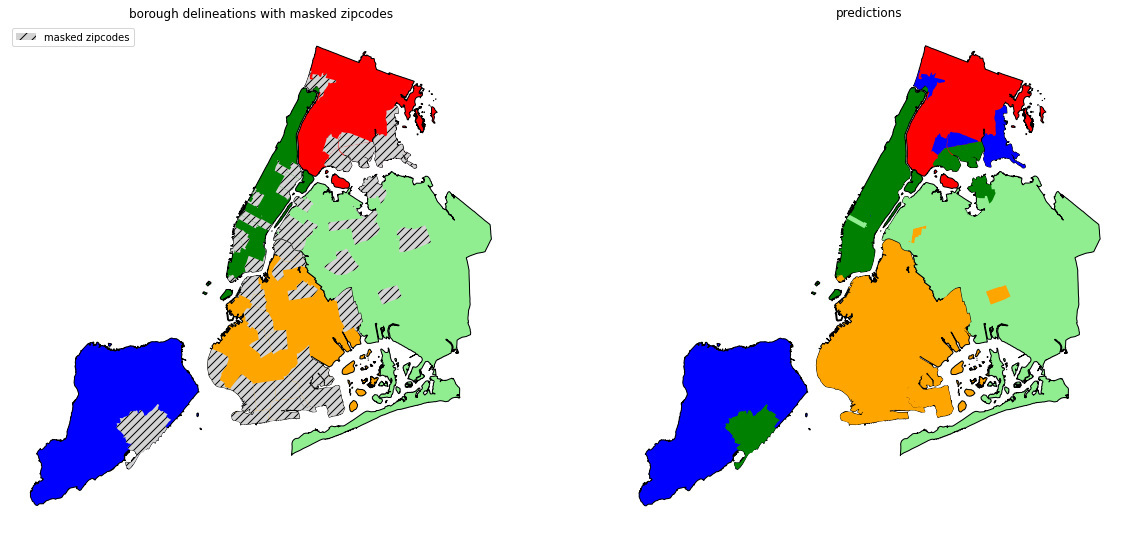

In [317]:
zips = gpd.read_file('ZIP_CODE_040114.shp')
zips['ZIPCODE'] = pd.to_numeric(zips['ZIPCODE'])
zips = zips.to_crs(epsg=4326)

zipsAll = data.groupby(by='origin', as_index=False).sum()
zipsAll = zipsAll.merge(zips, left_on='origin', right_on='ZIPCODE')
zipsAll.drop_duplicates(subset=['origin'], inplace=True)
zipsAll.reset_index(drop=True, inplace=True)
zipsAll = gpd.GeoDataFrame(zipsAll, crs="EPSG:4326", geometry='geometry')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,12))

boro = gpd.read_file('Borough Boundaries.zip')
boro.plot(figsize=(10,10), ax=ax[0])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']

for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[0])
zipsMasked = zipsAll[zipsAll.index.isin(random_indices)][['origin', 'geometry']]

zipsMasked.plot(facecolor='lightgrey',hatch='///', ax=ax[0], label='masked zipcodes')
    
LegendElement = [mpatches.Patch(facecolor='lightgrey', hatch='//', label='masked zipcodes')]
ax[0].axis('off')
ax[0].legend(handles = LegendElement, loc='upper left')
ax[0].set_title('borough delineations with masked zipcodes')

boro.plot(figsize=(10,10), ax=ax[1])

colors = ['r', 'g', 'b', 'orange', 'lightgreen']
# colors = ['g', 'r', 'orange', 'lightgreen', 'b']

for ind, b in enumerate(boro.boro_code):
    boro[boro.boro_code == b].plot(color=colors[ind], edgecolor="black", ax=ax[1])
zipsMasked = zipsAll[zipsAll.index.isin(random_indices)][['origin', 'geometry']]

pred = torch.argmax(op[0], dim=1).numpy()+1
zipsMasked['pred'] = pred[random_indices]

for p in zipsMasked.pred.unique():
    zipsMasked[zipsMasked.pred == p].plot(color=colors[p], ax=ax[1])
    
ax[1].axis('off')
ax[1].set_title('predictions')